# CS194-26 Project 5 Facial Keypoint Detection with Neural Networks

Note that the workspace is mounting to Google Drive. All the input data should be prepared under `/content/drive/cs194-26-proj5` before running. Also note that each part should be able to run independently.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
ws_dir = '/content/drive/MyDrive/cs194-26-proj5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Import Section

import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.transform as skT
import skimage.io as skio
import cv2

import itertools
import sys
import os
import glob

In [3]:
## Defining Basic Functions

def normalize_clip(im):
    return np.minimum(np.maximum(im, 0), 1)

def normalize(im):
    return (im-np.min(im))/(np.max(im)-np.min(im))

def rgb2gray(rgb):
    return rgb.dot([0.2989, 0.5870, 0.1140])


## Part 1: Nose Tip Detection

In [ ]:
# Dataloader

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        im, keypoint = sample
        im = im.transpose((2, 0, 1)) # swap color axis to (c, h, w)
        return torch.from_numpy(im), torch.from_numpy(keypoint)

class NoseTipDataset(Dataset):

    def __init__(self, split: str = "train", transform=None):
        assert split in ("train", "validation")
        data_range = range(1, 33) if split == "train" else range(32, 41)
        self.nose_keypoints, self.images, self.transform = [], [], transform
        
        progress_bar = tqdm.tqdm(data_range)
        for i in progress_bar:
            for j in range(1, 7):
                root_dir = os.path.join(ws_dir, 'imm_face_db')
                file_path = glob.glob(os.path.join(root_dir, '{:02d}-{:d}*.asf'.format(i,j)))[0]
                file_rt_path, _ = os.path.splitext(file_path)
                
                # load the face image
                im = sk.img_as_float(skio.imread(file_rt_path+".jpg"))
                im = (rgb2gray(im)-0.5)[:, :, None]
                im = skT.resize(im, (60, 80))
                im = im.astype('float32')

                # load all facial keypoints/landmarks
                with open(file_path) as f:
                    points = f.readlines()[16:74]
                landmark = []
                for point in points:
                    x,y = point.split('\t')[2:4]
                    landmark.append([float(x), float(y)])
                # the nose keypoint
                nose_keypoint = np.array(landmark).astype('float32')[-6]
                
                self.images.append(im) # cropped and resized images in cache
                self.nose_keypoints.append(nose_keypoint)

    def __len__(self) -> int:
        return len(self.nose_keypoints)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.images[idx], self.nose_keypoints[idx]
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [ ]:
my_transforms = transforms.Compose([
    ToTensor()
])
train_dataset = NoseTipDataset(split="train", transform=my_transforms)
train_loader = DataLoader(train_dataset, batch_size=64)

test_dataset = NoseTipDataset(split="validation", transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


In [ ]:
def show_keypoint(im, keypoint):
    h, w = im.shape[1:]
    plt.imshow(torch.permute(im, (1, 2, 0))[:, :, 0], cmap="gray")
    plt.plot(keypoint[0]*w, keypoint[1]*h, 'go', markersize=15)

# show some samples
save_dir = os.path.join(ws_dir, "output/pt1")
os.makedirs(save_dir, exist_ok=True)

ims, nose_keypoints = next(iter(train_loader))[:4]
for i in range(4):
    im, nose_keypoint = ims[i], nose_keypoints[i]
    plt.figure()
    show_keypoint(im, nose_keypoint)
    plt.savefig(os.path.join(save_dir, f"sample{i+1}.jpg"), dpi=100)
    plt.close()

In [ ]:
# CNN

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(1, 12, 7)
    self.conv2 = nn.Conv2d(12, 16, 5)
    self.conv3 = nn.Conv2d(16, 32, 3)
    # fully connected layers
    self.fc1 = nn.Linear(896, 128)  # 4*7 from image dimension
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2) # (27, 37)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2) # (11 ,16)
    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2) # (4, 7)
    
    x = torch.flatten(x, 1) # b c h w -> b c
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

net = Net().cuda()
print(net)

Net(
  (conv1): Conv2d(1, 12, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=896, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
# Training

import tqdm

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

num_epochs = 25
train_losses, test_losses = [], [] # loss for every epoch
for epoch in range(num_epochs):
    
    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []

    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        # forward pass
        outputs = net(inputs)
        # compute loss
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        # update network parameters
        optimizer.step()

        # print statistics
        running_losses.append(loss.item())
        progress_bar.set_description(f"Loss: {loss}")

    
    # train loss
    train_losses.append(sum(running_losses)/len(running_losses))
    
    # validation loss
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        test_losses.append(loss.item())

# save the network
torch.save(net.state_dict(), os.path.join(save_dir, 'checkpoint.pt'))

Loss: 0.004328928422182798: 100%|██████████| 3/3 [00:00<00:00, 148.73it/s]


In [ ]:
# reload the pre-saved network
state_dict = torch.load(os.path.join(save_dir, 'checkpoint.pt'))
net.load_state_dict(state_dict)

<All keys matched successfully>

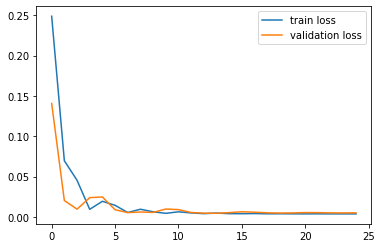

Final train loss: 0.0036310978854695954, validation loss: 0.004975700285285711


In [ ]:
plt.figure()
plt.plot(np.arange(num_epochs), train_losses, label='train loss')
plt.plot(np.arange(num_epochs), test_losses, label='validation loss')
plt.legend()
plt.savefig(os.path.join(save_dir, f"loss.jpg"), dpi=500)
plt.show()
print(f"Final train loss: {train_losses[-1]}, validation loss: {test_losses[-1]}")

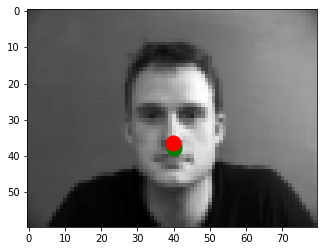

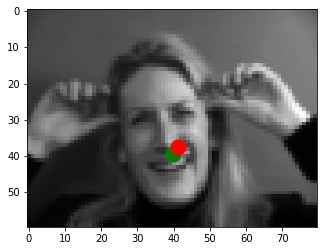

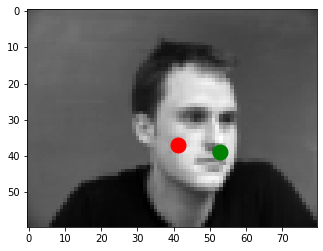

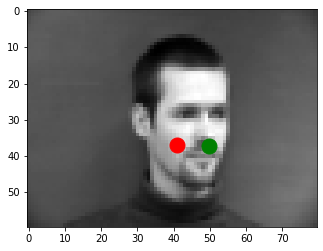

In [ ]:
# show correct and incorrect examples

def show_keypoint2(im, ground_truth, pred):
    h, w = im.shape[1:]
    plt.imshow(torch.permute(im, (1, 2, 0))[:, :, 0], cmap="gray")
    plt.plot(ground_truth[0]*w, ground_truth[1]*h, 'go', markersize=15)
    plt.plot(pred[0]*w, pred[1]*h, 'ro', markersize=15)

with torch.no_grad():
    inputs, labels = next(iter(test_loader))
    outputs = net(inputs.cuda()).cpu()
for i in [28, 23]:
    plt.figure()
    show_keypoint2(inputs[i], labels[i], outputs[i])
    plt.savefig(os.path.join(save_dir, f"correct{i+1}.jpg"), dpi=100)
    plt.show()
for i in [27, 15]:
    plt.figure()
    show_keypoint2(inputs[i], labels[i], outputs[i])
    plt.savefig(os.path.join(save_dir, f"incorrect{i+1}.jpg"), dpi=100)
    plt.show()

In [ ]:
del net
del train_dataset
del test_dataset

## Part 2: Full Facial Keypoints Detection

In [ ]:
# Dataloader

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm

class ToPILImage(object):
    """Convert numpyImage in sample to PILImage."""
    
    def __call__(self, sample):
        im, landmark = sample
        return transforms.ToPILImage()(im), landmark

class ToTensor(object):
    """Convert ndarrays or PILImage in sample to Tensors."""
    
    def __call__(self, sample):
        im, landmark = sample
        return transforms.functional.to_tensor(im), torch.from_numpy(landmark.astype("float32"))
        # Note: transforms.functional.to_tensor automatically convert to [0, 1] float32 tensor
    
class Normalize(object):
    """Normalize the tensor image in sample."""
    
    def __init__(self, mean, std):
        self.Normalize = transforms.Normalize(mean=mean, std=std)
    
    def __call__(self, sample):
        im, landmark = sample
        return self.Normalize(im), landmark

from math import sin, cos
    
class RandomRotation(object):
    """Randomly rotate the image for some degrees."""
    
    def __init__(self, degrees=0):
        self.degrees = degrees
        
    def get_random(self):
        angle = torch.empty(1).uniform_(-self.degrees, self.degrees).item()
        return angle

    def __call__(self, sample):
        im, landmark = sample
        angle = self.get_random()
        w, h = im.size
        # rotate the image
        im = transforms.functional.rotate(im, angle, center=(w/2, h/2))
        # rotate landmarks correspondingly
        landmark = landmark * [w, h] - [w/2, h/2]
        theta = np.deg2rad(-angle)
        rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
        landmark = (rot@landmark.T).T
        landmark = (landmark + [w/2, h/2])/[w, h]
        
        return im, landmark
    
class RandomShifting(object):
    """Randomly shift the image."""
    
    def __init__(self, translate=(0, 0)): # Note: translate = (width, height)
        self.translate = translate
    
    def get_random(self):
        delta_x = torch.randint(-self.translate[0], self.translate[0]+1, (1,)).item()
        delta_y = torch.randint(-self.translate[1], self.translate[1]+1, (1,)).item()
        return delta_x, delta_y
    
    def __call__(self, sample):
        im, landmark = sample
        w, h = im.size
        vec = self.get_random()
        landmark = landmark + np.array(vec)/[w, h]
        return transforms.functional.affine(im, angle=0, translate=vec, scale=1, shear=0), landmark
    
    
class ColorJitter(object):
    """Randomly change the brightness and the saturation."""
    
    def __init__(self, brightness=0, saturation=0):
        self.ColorJitter = transforms.ColorJitter(brightness=brightness, saturation=saturation)
        
    def __call__(self, sample):
        im, landmark = sample
        return self.ColorJitter(im), landmark
    

class FaceLandmarksDataset(Dataset):

    def __init__(self, split: str = "train", transform=None):
        assert split in ("train", "validation")
        data_range = range(1, 33) if split == "train" else range(32, 41)
        self.landmarks, self.images, self.transform = [], [], transform
        
        progress_bar = tqdm.tqdm(data_range)
        for i in progress_bar:
            for j in range(1, 7):
                root_dir = os.path.join(ws_dir, 'imm_face_db')
                file_path = glob.glob(os.path.join(root_dir, '{:02d}-{:d}*.asf'.format(i,j)))[0]
                file_rt_path, _ = os.path.splitext(file_path)
                
                # load the face image, Note: normalization is in transforms
                im = skio.imread(file_rt_path+".jpg")
                im = rgb2gray(im)[:, :, None]
                im = skT.resize(im, (180, 240))
                im = im.astype('uint8') # Note: dtype must be int

                # load all facial keypoints/landmarks
                with open(file_path) as f:
                    points = f.readlines()[16:74]
                landmark = []
                for point in points:
                    x,y = point.split('\t')[2:4]
                    landmark.append([float(x), float(y)])
                landmark = np.array(landmark)
                
                self.images.append(im) # cropped and resized images in cache
                self.landmarks.append(landmark)

    def __len__(self) -> int:
        return len(self.landmarks)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.images[idx], self.landmarks[idx]
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [ ]:
my_transforms = transforms.Compose([
    ToPILImage(),
    RandomShifting(translate=(20, 20)),
    RandomRotation(degrees=15),
    # ColorJitter(brightness=0.3),
    ToTensor(),
    Normalize(mean=[0.5], std=[1.]) # normalize from [0, 1] -> [-1, 1]
])
test_transforms = transforms.Compose([ # without data augmentation
    ToPILImage(),
    ToTensor(),
    Normalize(mean=[0.5], std=[1.])
])

train_dataset = FaceLandmarksDataset(split="train", transform=my_transforms)
train_loader = DataLoader(train_dataset, batch_size=8)

test_dataset = FaceLandmarksDataset(split="validation", transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

100%|██████████| 9/9 [00:01<00:00,  5.04it/s]


In [ ]:
def show_landmarks(im, landmark):
    h, w = im.shape[1:]
    plt.imshow(torch.permute(im, (1, 2, 0))[:, :, 0], cmap="gray")
    plt.plot(landmark[:, 0]*w, landmark[:, 1]*h, 'go', markersize=3)
    
# show some samples
save_dir = os.path.join(ws_dir, "output/pt2")
os.makedirs(save_dir, exist_ok=True)
ims, landmarks = next(iter(train_loader))[:4]
for i in range(4):
    im, landmark = ims[i], landmarks[i]
    plt.figure()
    show_landmarks(im, landmark)
    plt.savefig(os.path.join(save_dir, f"sample{i+1}.jpg"), dpi=500)
    plt.close()

In [ ]:
# CNN

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(1, 12, 3)
    self.conv2 = nn.Conv2d(12, 24, 3)
    self.conv3 = nn.Conv2d(24, 48, 3)
    self.conv4 = nn.Conv2d(48, 96, 3)
    self.conv5 = nn.Conv2d(96, 192, 3)
    # fully connected layers
    self.fc1 = nn.Linear(2880, 1024)
    self.fc2 = nn.Linear(1024, 116)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    
    x = torch.flatten(x, 1) # b c h w -> b c
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

net = Net().cuda()
print(net)

Net(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2880, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=116, bias=True)
)


In [ ]:
# Training

import tqdm

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

num_epochs = 30
train_losses, test_losses = [], []
for epoch in range(num_epochs):
    
    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []
    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1, 116))
        loss.backward()
        optimizer.step()

        # print statistics
        running_losses.append(loss.item())
        progress_bar.set_description(f"Loss: {loss}")
    
    # train loss
    train_losses.append(sum(running_losses)/len(running_losses))
    
    # validation loss
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda().view(-1, 116))
        test_losses.append(loss.item())

# save the network
torch.save(net.state_dict(), os.path.join(save_dir, 'checkpoint.pt'))

Loss: 0.0010769990039989352: 100%|██████████| 24/24 [00:00<00:00, 73.62it/s]


In [ ]:
# reload the pre-saved network
state_dict = torch.load(os.path.join(save_dir, 'checkpoint.pt'))
net.load_state_dict(state_dict)

<All keys matched successfully>

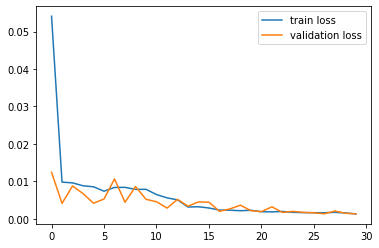

Final train loss: 0.0013158461806597188, validation loss: 0.0013039375189691782


In [ ]:
plt.figure()
plt.plot(np.arange(num_epochs), train_losses, label='train loss')
plt.plot(np.arange(num_epochs), test_losses, label='validation loss')
plt.legend()
plt.savefig(os.path.join(save_dir, f"loss.jpg"), dpi=500)
plt.show()
print(f"Final train loss: {train_losses[-1]}, validation loss: {test_losses[-1]}")

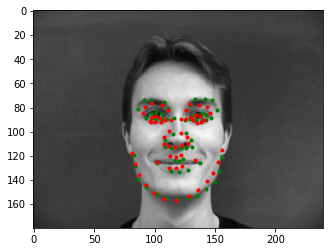

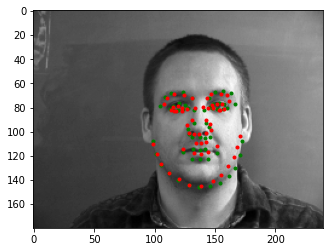

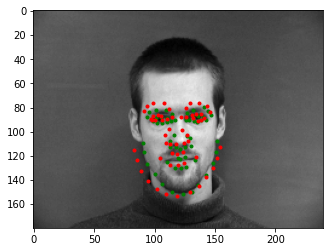

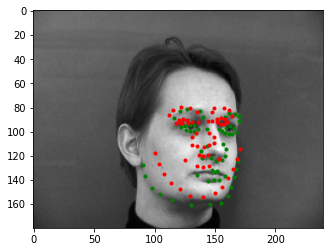

In [ ]:
# show correct and incorrect examples

def show_landmarks2(im, ground_truth, pred):
    h, w = im.shape[1:]
    plt.imshow(torch.permute(im, (1, 2, 0))[:, :, 0], cmap="gray")
    plt.plot(ground_truth[:, 0]*w, ground_truth[:, 1]*h, 'go', markersize=3)
    plt.plot(pred[:, 0]*w, pred[:, 1]*h, 'ro', markersize=3)

with torch.no_grad():
    inputs, labels = next(iter(test_loader))
    outputs = net(inputs.cuda()).cpu()
    outputs.resize_((labels.size(0), 58, 2))

for i in [37, 46]:
    plt.figure()
    show_landmarks2(inputs[i], labels[i], outputs[i])
    plt.savefig(os.path.join(save_dir, f"correct{i+1}.jpg"), dpi=100)
    plt.show()

for i in [12, 33]:
    plt.figure()
    show_landmarks2(inputs[i], labels[i], outputs[i])
    plt.savefig(os.path.join(save_dir, f"incorrect{i+1}.jpg"), dpi=100)
    plt.show()

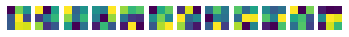

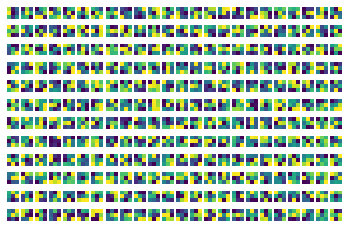

In [ ]:
# visualize learned filters

conv1_filter = list(net.conv1.parameters())[0].data.cpu()
plt.figure()
for i in range(1):
    for j in range(12):
        plt.subplot(1, 12, j+1)
        plt.imshow(conv1_filter[j][i])
        plt.axis("off")
plt.savefig(os.path.join(save_dir, "conv1_filter.jpg"), dpi=500)
plt.show()

conv2_filter = list(net.conv2.parameters())[0].data.cpu()
plt.figure()
for i in range(12):
    for j in range(24):
        plt.subplot(12, 24, i*24+j+1)
        plt.imshow(conv2_filter[j][i])
        plt.axis("off")
plt.savefig(os.path.join(save_dir, "conv2_filter.jpg"), dpi=500)
plt.show()

In [ ]:
del net
del train_dataset
del test_dataset

## Part 3: Train With Larger Dataset

In [ ]:
# Dataloader

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET 
import tqdm

def crop_im(im, box):
    pad_x = -box[0] if box[0] < 0 else 0
    pad_y = -box[1] if box[1] < 0 else 0
    box[0], box[1] = max(box[0], 0), max(box[1], 0)
    im = np.pad(im, ((pad_y, 0), (pad_x, 0), (0, 0)))
    im = im[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
    return im

class LargeFaceLandmarksDataset(Dataset):

    def __init__(self, split: str = "train", transform=None, return_boxes=False, return_ori=False):
        assert split in ("train", "validation", "my_collection", "kaggle")
        data_l, data_r = (0, 5555) if split == "train" else (5555, 6666)

        self.length = data_r-data_l
        self.images, self.landmarks, self.transform = [], [], transform
        self.return_boxes, self.return_ori = return_boxes, return_ori

        if split == "my_collection":
            self.length = 3

            root_dir = os.path.join(ws_dir, "my_collection")
            bboxes, img_filenames = [], []
            with open(os.path.join(root_dir, "face_box.txt")) as f:
                f.readline()
                for i in range(3):
                    rdl = f.readline().strip().split(',')
                    bboxes.append([int(rdl[0]), int(rdl[1]), int(rdl[2]), int(rdl[3])])
                    img_filenames.append(os.path.join(root_dir, f"{i+1}.jpg"))
            bboxes = np.array(bboxes).astype('int')

            self.bboxes = bboxes
            self.img_filenames = img_filenames
            if return_boxes or return_ori:
                return 

            for i in range(3):
                box = bboxes[i]
                im = skio.imread(img_filenames[i])
                # to grayscale
                im = rgb2gray(im)[:, :, None] if im.ndim == 3 else im[:, :, None]
                # crop the image
                im = crop_im(im, box)
                # resize the image
                im = skT.resize(im, (224, 224))
                if im.max() < 1:
                    im = im*255.
                im = im.astype('uint8')

                self.images.append(im)
                self.landmarks.append(np.zeros((68, 2))) # Note: no actual landmark
            return

        if split == "kaggle":
            tree = ET.parse(os.path.join(ws_dir, 'kaggle/labels_ibug_300W_test_parsed.xml'))
            root = tree.getroot()
            root_dir = os.path.join(ws_dir, 'ibug_300W_large_face_landmark_dataset')

            bboxes = [] # face bounding box used to crop the image
            img_filenames = [] # the image names for the whole dataset

            for filename in root[2]:
                img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
                box = filename[0].attrib
                # x, y for the top left corner of the box, w, h for box width and height
                bboxes.append([box['left'], box['top'], box['width'], box['height']])
            bboxes = np.array(bboxes).astype('int') 

            self.bboxes = bboxes
            self.img_filenames = img_filenames
            if return_boxes or return_ori:
                return 

            self.length = len(img_filenames)
            progress_bar = tqdm.tqdm(range(self.length))
            for i in progress_bar:
                box = bboxes[i]
                im = skio.imread(img_filenames[i])
                # to grayscale
                im = rgb2gray(im)[:, :, None] if im.ndim == 3 else im[:, :, None]
                # crop the image
                im = crop_im(im, box)
                # resize the image
                im = skT.resize(im, (224, 224))
                if im.max() < 1:
                    im = im*255.
                im = im.astype('uint8')

                self.images.append(im)
                self.landmarks.append(np.zeros((68, 2))) # Note: no actual landmark
            return


        
        tree = ET.parse(os.path.join(ws_dir, 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'))
        root = tree.getroot()
        root_dir = os.path.join(ws_dir, 'ibug_300W_large_face_landmark_dataset')

        bboxes = [] # face bounding box used to crop the image
        landmarks = [] # the facial keypoints/landmarks for the whole training dataset
        img_filenames = [] # the image names for the whole dataset

        for filename in root[2]:
            img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
            box = filename[0].attrib
            # x, y for the top left corner of the box, w, h for box width and height
            bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            landmarks.append(landmark)

        landmarks = np.array(landmarks).astype('float32')     
        bboxes = np.array(bboxes).astype('int')
        
        self.bboxes = bboxes[data_l:data_r]
        self.img_filenames = img_filenames[data_l:data_r]
        if return_boxes or return_ori:
            return 

        progress_bar = tqdm.tqdm(range(data_l, data_r))
        for i in progress_bar:
            box = bboxes[i]
            im = skio.imread(img_filenames[i])
            # to grayscale
            im = rgb2gray(im)[:, :, None] if im.ndim == 3 else im[:, :, None]
            # crop the image
            im = crop_im(im, box)
            # resize the image
            im = skT.resize(im, (224, 224))
            if im.max() < 1:
                im = im*255.
            im = im.astype('uint8')
            landmark = (landmarks[i]-[box[0], box[1]])/[box[2], box[3]]
            
            self.images.append(im) # cropped and resized images in cache
            self.landmarks.append(landmark)

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.return_boxes:
            return self.bboxes[idx]

        if self.return_ori:
            im = skio.imread(self.img_filenames[idx])
            return im
        
        sample = self.images[idx], self.landmarks[idx]
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [ ]:
train_dataset = LargeFaceLandmarksDataset(split="train", transform=my_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=2)

test_dataset = LargeFaceLandmarksDataset(split="validation", transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), num_workers=2)

In [ ]:
# show some samples
save_dir = os.path.join(ws_dir, "output/pt3")
os.makedirs(save_dir, exist_ok=True)
ims, landmarks = next(iter(train_loader))[:4]
for i in range(4):
    im, landmark = ims[i], landmarks[i]
    plt.figure()
    show_landmarks(im, landmark)
    plt.savefig(os.path.join(save_dir, f"sample{i+1}.jpg"), dpi=500)
    plt.close()

In [ ]:
# CNN: ResNet-18

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

net = resnet18(weights=ResNet18_Weights.DEFAULT)
# modifications
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc = nn.Linear(in_features=512, out_features=136, bias=True)
net = net.cuda()
print(net)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Training

import tqdm

criterion = nn.MSELoss()

train_losses, test_losses = [], []

# 10 epochs with lr=2e-4
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4)
num_epochs = 10
for epoch in range(num_epochs):
    
    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []
    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1, 136))
        loss.backward()
        optimizer.step()

        # print statistics
        running_losses.append(loss.item())
        progress_bar.set_description(f"Loss: {loss}")
    
    # train loss
    train_losses.append(sum(running_losses)/len(running_losses))
    
    # validation loss
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda().view(-1, 136))
        test_losses.append(loss.item())

# 10 epochs with lr=5e-5
optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)
num_epochs = 10
for epoch in range(num_epochs):
    
    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []
    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1, 136))
        loss.backward()
        optimizer.step()

        # print statistics
        running_losses.append(loss.item())
        progress_bar.set_description(f"Loss: {loss}")
    
    # train loss
    train_losses.append(sum(running_losses)/len(running_losses))
    
    # validation loss
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda().view(-1, 136))
        test_losses.append(loss.item())

# save the network
torch.save(net.state_dict(), os.path.join(save_dir, 'checkpoint.pt'))

Loss: 0.00028547467081807554: 100%|██████████| 695/695 [00:20<00:00, 33.47it/s]


In [ ]:
# reload the pre-saved network
state_dict = torch.load(os.path.join(save_dir, 'checkpoint.pt'))
net.load_state_dict(state_dict)

<All keys matched successfully>

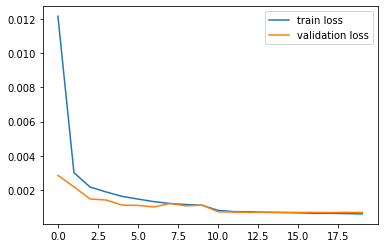

Final train loss: 0.000590269188162127, validation loss: 0.0006768728489987552


In [ ]:
plt.figure()
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
plt.plot(np.arange(len(test_losses)), test_losses, label='validation loss')
plt.legend()
plt.savefig(os.path.join(save_dir, f"loss.jpg"), dpi=500)
plt.show()
print(f"Final train loss: {train_losses[-1]}, validation loss: {test_losses[-1]}")

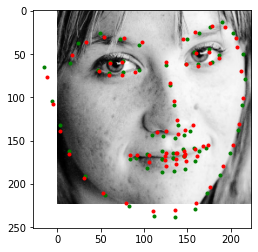

In [ ]:
# visualize some images in the test set

with torch.no_grad():
    inputs, labels = next(iter(test_loader))
    outputs = net(inputs.cuda()).cpu()
    outputs.resize_((labels.size(0), 68, 2))

show_landmarks2(inputs[10], labels[10], outputs[10])

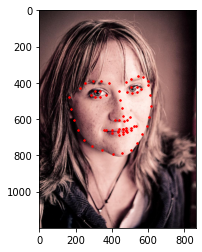

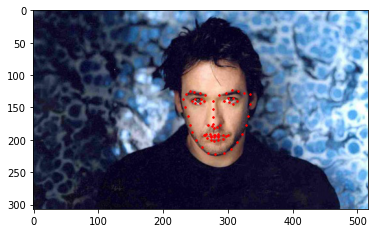

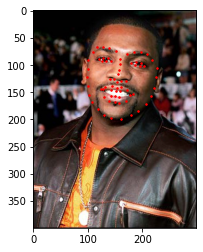

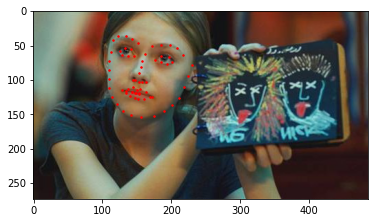

In [ ]:
def show_ori_landmarks(im, pred):
    h, w = im.shape[:2]
    plt.imshow(im) if im.ndim == 3 else plt.imshow(im, cmap="gray")
    plt.plot(pred[:, 0], pred[:, 1], 'ro', markersize=1.5)

with torch.no_grad():
    inputs, labels = next(iter(test_loader))
    outputs = net(inputs.cuda()).cpu()
    outputs.resize_((labels.size(0), 68, 2))

box_dataset = LargeFaceLandmarksDataset(split="validation", return_boxes=True)
im_dataset = LargeFaceLandmarksDataset(split="validation", return_ori=True)

# show the original image along with the landmarks
for i in [10, 33, 166, 999]:
    landmark, box = outputs[i].numpy(), box_dataset[i]
    landmark = landmark*[box[2], box[3]]+[box[0], box[1]]
    plt.figure()
    show_ori_landmarks(im_dataset[i], landmark)
    plt.savefig(os.path.join(save_dir, f"example{i+1}.jpg"), dpi=500)
    plt.show()

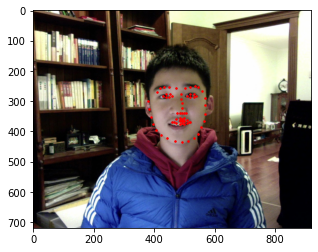

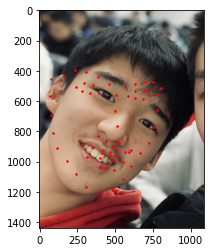

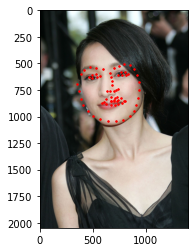

In [ ]:
# run on my collection

my_dataset = LargeFaceLandmarksDataset(split="my_collection", transform=test_transforms)
my_loader = DataLoader(my_dataset, batch_size=len(my_dataset), num_workers=2)

with torch.no_grad():
    inputs, labels = next(iter(my_loader))
    outputs = net(inputs.cuda()).cpu()
    outputs.resize_((labels.size(0), 68, 2))

box_dataset = LargeFaceLandmarksDataset(split="my_collection", return_boxes=True)
im_dataset = LargeFaceLandmarksDataset(split="my_collection", return_ori=True)

# show the original image along with the landmarks
for i in range(len(my_dataset)):
    landmark, box = outputs[i].numpy(), box_dataset[i]
    landmark = landmark*[box[2], box[3]]+[box[0], box[1]]
    plt.figure()
    show_ori_landmarks(im_dataset[i], landmark)
    plt.savefig(os.path.join(save_dir, f"my{i+1}.jpg"), dpi=500)
    plt.show()

In [ ]:
# run kaggle test

kaggle_dataset = LargeFaceLandmarksDataset(split="kaggle", transform=test_transforms)
kaggle_loader = DataLoader(kaggle_dataset, batch_size=len(kaggle_dataset), num_workers=2)

In [ ]:
with torch.no_grad():
    inputs, labels = next(iter(kaggle_loader))
    outputs = net(inputs.cuda()).cpu()
    outputs.resize_((labels.size(0), 68, 2))

box_dataset = LargeFaceLandmarksDataset(split="kaggle", return_boxes=True)

# save the predicted landmarks in the original image
id = 0
with open(os.path.join(ws_dir, 'kaggle/results.csv'), "w") as f:
    f.write("Id,Predicted\n")
    for i in range(len(kaggle_dataset)):
        landmark, box = outputs[i].numpy(), box_dataset[i]
        landmark = landmark*[box[2], box[3]]+[box[0], box[1]]
        for j in range(68):
            f.write(f"{id},{landmark[j, 0]}\n"); id += 1
            f.write(f"{id},{landmark[j, 1]}\n"); id += 1

In [ ]:
del net
del train_dataset
del test_dataset
del my_dataset
del box_dataset
del im_dataset
del kaggle_dataset

## Part 4: Pixelwise Classification

In [59]:
# Dataloader

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET 
import tqdm

def crop_im(im, box):
    pad_x = -box[0] if box[0] < 0 else 0
    pad_y = -box[1] if box[1] < 0 else 0
    box[0], box[1] = max(box[0], 0), max(box[1], 0)
    im = np.pad(im, ((pad_y, 0), (pad_x, 0), (0, 0)))
    im = im[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
    return im

def get_gaussian_kernel_2d(ksize, sigma):
    # get 1d kernel as a 1 column matrix
    k1d = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
    return k1d @ k1d.T

def crop_im(im, box):
    pad_x = -box[0] if box[0] < 0 else 0
    pad_y = -box[1] if box[1] < 0 else 0
    box[0], box[1] = max(box[0], 0), max(box[1], 0)
    im = np.pad(im, ((pad_y, 0), (pad_x, 0), (0, 0)))
    im = im[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
    return im

def get_gaussian_kernel_2d(ksize, sigma):
    # get 1d kernel as a 1 column matrix
    k1d = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
    return k1d @ k1d.T

def to_heatmap(im, landmark):
    im = skT.resize(im, (142, 142, 1))
    im = np.pad(im, ((57, 57), (57, 57), (0, 0)))

    landmark = (landmark*142+57).astype("uint8")
    heatmap = []
    for i in range(68):
        hm = np.zeros((256, 256))
        gauss_kernel = get_gaussian_kernel_2d(13, 5)
        hm[landmark[i, 1]-6:landmark[i, 1]+7, landmark[i, 0]-6:landmark[i, 0]+7] = gauss_kernel
        heatmap.append(hm)
    heatmap = np.array(heatmap)
    return im, heatmap

class ToTensor(object):
    """Convert ndarrays or PILImage in sample to Tensors."""
    
    def __call__(self, sample):
        im, heatmap = sample
        return transforms.functional.to_tensor(im), torch.from_numpy(heatmap)
    
class Normalize(object):
    """Normalize the tensor image in sample."""
    
    def __init__(self, mean, std):
        self.Normalize = transforms.Normalize(mean=mean, std=std)
    
    def __call__(self, sample):
        im, heatmap = sample
        return self.Normalize(im).type(torch.FloatTensor), heatmap.type(torch.FloatTensor) # Note: cast to Float32
    
class RandomRotation(object):
    """Randomly rotate the image for some degrees."""
    
    def __init__(self, degrees=0):
        self.degrees = degrees
        
    def get_random(self):
        angle = torch.empty(1).uniform_(-self.degrees, self.degrees).item()
        return angle

    def __call__(self, sample):
        im, heatmap = sample # Note: im is a tensor, different from previous parts
        angle = self.get_random()
        h, w = im.shape[1:]
        # rotate the image and the heatmap
        im = transforms.functional.rotate(im, angle, center=(w/2, h/2))
        heatmap = transforms.functional.rotate(heatmap, angle, center=(w/2, h/2))
        return im, heatmap

class RandomShifting(object):
    """Randomly shift the image."""
    
    def __init__(self, translate=(0, 0)): # Note: translate = (width, height)
        self.translate = translate
    
    def get_random(self):
        delta_x = torch.randint(-self.translate[0], self.translate[0]+1, (1,)).item()
        delta_y = torch.randint(-self.translate[1], self.translate[1]+1, (1,)).item()
        return delta_x, delta_y
    
    def __call__(self, sample):
        im, heatmap = sample # Note: im is a tensor, different from previous parts
        vec = self.get_random()
        im = transforms.functional.affine(im, angle=0, translate=vec, scale=1, shear=0)
        heatmap = transforms.functional.affine(heatmap, angle=0, translate=vec, scale=1, shear=0)
        return im, heatmap

class FaceHeatmapDataset(Dataset):

    def __init__(self, split: str = "train", transform=None, return_boxes=False, return_ori=False):
        assert split in ("train", "validation", "my_collection", "kaggle")
        data_l, data_r = (0, 1111) if split == "train" else (5555, 5888)

        self.length = data_r-data_l
        self.images, self.heatmaps, self.transform = [], [], transform
        self.return_boxes, self.return_ori = return_boxes, return_ori

        if split == "my_collection":
            self.length = 3

            root_dir = os.path.join(ws_dir, "my_collection")
            bboxes, img_filenames = [], []
            with open(os.path.join(root_dir, "face_box.txt")) as f:
                f.readline()
                for i in range(3):
                    rdl = f.readline().strip().split(',')
                    bboxes.append([int(rdl[0]), int(rdl[1]), int(rdl[2]), int(rdl[3])])
                    img_filenames.append(os.path.join(root_dir, f"{i+1}.jpg"))
            bboxes = np.array(bboxes).astype('int')

            self.bboxes = bboxes
            self.img_filenames = img_filenames
            if return_boxes or return_ori:
                return 

            for i in range(3):
                box = bboxes[i]
                im = skio.imread(img_filenames[i])
                # to grayscale
                im = rgb2gray(im)[:, :, None] if im.ndim == 3 else im[:, :, None]
                # crop the image
                im = crop_im(im, box)
                # resize the image
                im = skT.resize(im, (224, 224))
                if im.max() < 1:
                    im = im*255.
                im = im.astype('uint8')

                im = skT.resize(im, (142, 142, 1))
                im = np.pad(im, ((57, 57), (57, 57), (0, 0)))
                self.images.append(im)
                self.heatmaps.append(np.zeros((0,))) # Note: no actual heatmap
            return

        if split == "kaggle":
            tree = ET.parse(os.path.join(ws_dir, 'kaggle/labels_ibug_300W_test_parsed.xml'))
            root = tree.getroot()
            root_dir = os.path.join(ws_dir, 'ibug_300W_large_face_landmark_dataset')

            bboxes = [] # face bounding box used to crop the image
            img_filenames = [] # the image names for the whole dataset

            for filename in root[2]:
                img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
                box = filename[0].attrib
                # x, y for the top left corner of the box, w, h for box width and height
                bboxes.append([box['left'], box['top'], box['width'], box['height']])
            bboxes = np.array(bboxes).astype('int') 

            self.bboxes = bboxes
            self.img_filenames = img_filenames
            if return_boxes or return_ori:
                return 

            self.length = len(img_filenames)
            progress_bar = tqdm.tqdm(range(self.length))
            for i in progress_bar:
                box = bboxes[i]
                im = skio.imread(img_filenames[i])
                # to grayscale
                im = rgb2gray(im)[:, :, None] if im.ndim == 3 else im[:, :, None]
                # crop the image
                im = crop_im(im, box)
                # resize the image
                im = skT.resize(im, (224, 224))
                if im.max() < 1:
                    im = im*255.
                im = im.astype('uint8')

                im = skT.resize(im, (142, 142, 1))
                im = np.pad(im, ((57, 57), (57, 57), (0, 0)))
                self.images.append(im)
                self.heatmaps.append(np.zeros((0,))) # Note: no actual heatmap
            return
        
        tree = ET.parse(os.path.join(ws_dir, 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'))
        root = tree.getroot()
        root_dir = os.path.join(ws_dir, 'ibug_300W_large_face_landmark_dataset')

        bboxes = [] # face bounding box used to crop the image
        landmarks = [] # the facial keypoints/landmarks for the whole training dataset
        img_filenames = [] # the image names for the whole dataset

        for filename in root[2]:
            img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
            box = filename[0].attrib
            # x, y for the top left corner of the box, w, h for box width and height
            bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            landmarks.append(landmark)

        landmarks = np.array(landmarks).astype('float32')     
        bboxes = np.array(bboxes).astype('int')
        
        self.bboxes = bboxes[data_l:data_r]
        self.img_filenames = img_filenames[data_l:data_r]
        if return_boxes or return_ori:
            return 
        
        progress_bar = tqdm.tqdm(range(data_l, data_r))
        for i in progress_bar:
            box = bboxes[i]
            im = skio.imread(img_filenames[i])
            # to grayscale
            im = rgb2gray(im)[:, :, None] if im.ndim == 3 else im[:, :, None]
            # crop the image
            im = crop_im(im, box)
            # resize the image
            im = skT.resize(im, (224, 224))
            if im.max() < 1:
                im = im*255.
            im = im.astype('uint8')
            landmark = (landmarks[i]-[box[0], box[1]])/[box[2], box[3]]
            
            im, heatmap = to_heatmap(im, landmark)
            self.images.append(im)
            self.heatmaps.append(heatmap)

    def __len__(self) -> int:
        return self.length

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.return_boxes:
            return self.bboxes[idx]

        if self.return_ori:
            im = skio.imread(self.img_filenames[idx])
            return im
        
        sample = self.images[idx], self.heatmaps[idx]
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [ ]:
my_transforms = transforms.Compose([
    ToTensor(),
    RandomShifting(translate=(20, 20)),
    RandomRotation(degrees=15),
    Normalize(mean=[0.5], std=[1.]) # normalize from [0, 1] -> [-1, 1]
])
test_transforms = transforms.Compose([ # without data augmentation
    ToTensor(),
    Normalize(mean=[0.5], std=[1.])
])

train_dataset = FaceHeatmapDataset(split="train", transform=my_transforms)
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=2)

test_dataset = FaceHeatmapDataset(split="validation", transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2)

100%|██████████| 333/333 [00:43<00:00,  7.58it/s]


In [ ]:
# show some samples
def show_heatmap(im, heatmap):
    heatmaps = torch.sum(heatmap, axis=0)
    plt.subplot(221)
    plt.imshow(torch.permute(im, (1, 2, 0))[:, :, 0], cmap="gray")
    plt.subplot(222)
    plt.imshow(heatmaps)

save_dir = os.path.join(ws_dir, "output/pt4")
os.makedirs(save_dir, exist_ok=True)
ims, heatmaps = next(iter(train_loader))[:4]
for i in range(4):
    im, heatmap = ims[i], heatmaps[i]
    plt.figure()
    show_heatmap(im, heatmap)
    plt.savefig(os.path.join(save_dir, f"sample{i+1}.jpg"), dpi=500)
    plt.close()

In [5]:
# CNN

import torch.nn as nn
import torch.nn.functional as F
from unet import UNet

class MyUNet(UNet):
    def __init__(self, *args, **kwargs):
        super(MyUNet, self).__init__(*args, **kwargs)
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        output = torch.flatten(self.conv(dec1), start_dim=2, end_dim=-1)
        output = F.softmax(output, dim=2)
        return torch.reshape(output, (-1, 68, 256, 256))

net = MyUNet(in_channels=1, out_channels=68, init_features=68).cuda()
print(net)

MyUNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(68, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(68, 136, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(136, 136, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(136, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# Training

import tqdm

criterion = nn.L1Loss(reduction="sum")

train_losses, test_losses = [], []

# 10 epochs with lr=1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 10
for epoch in range(num_epochs):
    
    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []
    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_losses.append(loss.item())
        progress_bar.set_description(f"Loss: {loss}")
    
    # train loss
    train_losses.append(sum(running_losses)/len(running_losses))
    
    # validation loss
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = net(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
            running_losses.append(loss.item())
        test_losses.append(sum(running_losses)/len(running_losses))

# 20 epochs with lr=2e-4
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4)
num_epochs = 20
for epoch in range(num_epochs):
    
    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []
    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_losses.append(loss.item())
        progress_bar.set_description(f"Loss: {loss}")
    
    # train loss
    train_losses.append(sum(running_losses)/len(running_losses))
    
    # validation loss
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = net(inputs.cuda())
            loss = criterion(outputs, labels.cuda())
            running_losses.append(loss.item())
        test_losses.append(sum(running_losses)/len(running_losses))

Loss: 288.7132873535156: 100%|██████████| 139/139 [01:09<00:00,  2.00it/s]


In [21]:
# save the network
torch.save(net.state_dict(), os.path.join(save_dir, 'checkpoint.pt'))

In [7]:
# reload the pre-saved network
state_dict = torch.load(os.path.join(save_dir, 'checkpoint.pt'))
net.load_state_dict(state_dict)

<All keys matched successfully>

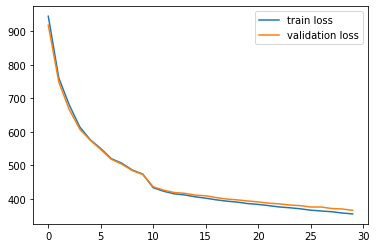

Final train loss: 355.2063120011803, validation loss: 365.88276866259497


In [22]:
plt.figure()
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
plt.plot(np.arange(len(test_losses)), test_losses, label='validation loss')
plt.legend()
plt.savefig(os.path.join(save_dir, f"loss.jpg"), dpi=500)
plt.show()
print(f"Final train loss: {train_losses[-1]}, validation loss: {test_losses[-1]}")

In [52]:
# visualize some images in the test set

with torch.no_grad():
    flag_unset = True
    for i, data in enumerate(test_loader):
        inputs, labels = data
        batch_outputs = net(inputs.cuda()).cpu().numpy()
        if flag_unset == True: 
            outputs = batch_outputs
            flag_unset = False
        else:
            outputs = np.append(outputs, batch_outputs, axis=0)  

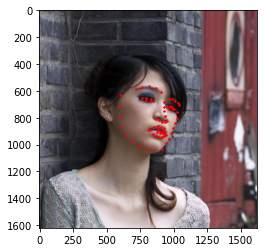

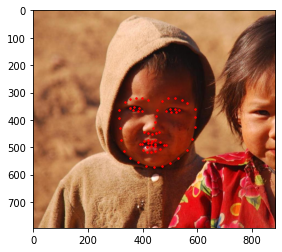

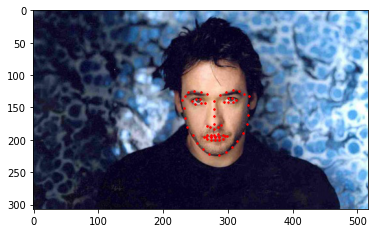

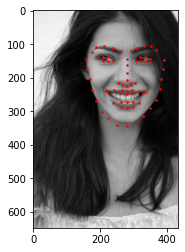

In [60]:
def show_ori_landmarks(im, pred):
    h, w = im.shape[:2]
    plt.imshow(im) if im.ndim == 3 else plt.imshow(im, cmap="gray")
    plt.plot(pred[:, 0], pred[:, 1], 'ro', markersize=1.5)

def heatmap_to_landmarks(heatmap):
    coords_x = np.tile(np.arange(256)[None, :], (256, 1))
    coords_y = np.tile(np.arange(256)[:, None], (1, 256))
    landmark = []
    for i in range(68):
        heatmap[i] = np.where(heatmap[i]<2e-4, 0, heatmap[i])
        x = np.sum(heatmap[i]*coords_x)/np.sum(heatmap[i])
        y = np.sum(heatmap[i]*coords_y)/np.sum(heatmap[i])
        landmark.append([x, y])
    # landmark = []
    # for i in range(68):
    #     x, y = np.where(heatmap[i] == np.max(heatmap[i]))
    #     x, y = x.item(), y.item()
    #     landmark.append([x, y])
    return np.array(landmark)

box_dataset = FaceHeatmapDataset(split="validation", return_boxes=True)
im_dataset = FaceHeatmapDataset(split="validation", return_ori=True)

# show the original image along with the landmarks
for i in [14, 15, 33, 52]:
    landmark, box = heatmap_to_landmarks(outputs[i]), box_dataset[i]
    landmark = (landmark-57)/142
    landmark = landmark*[box[2], box[3]]+[box[0], box[1]]
    plt.figure()
    show_ori_landmarks(im_dataset[i], landmark)
    plt.savefig(os.path.join(save_dir, f"example{i+1}.jpg"), dpi=500)
    plt.show()

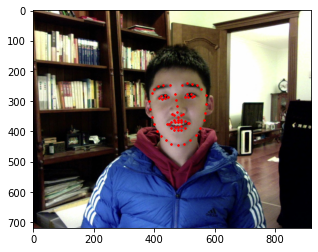

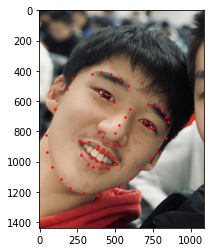

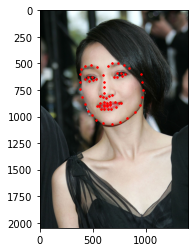

In [63]:
# run on my collection

my_dataset = FaceHeatmapDataset(split="my_collection", transform=test_transforms)
my_loader = DataLoader(my_dataset, batch_size=len(my_dataset))

with torch.no_grad():
    flag_unset = True
    for i, data in enumerate(my_loader):
        inputs, labels = data
        batch_outputs = net(inputs.cuda()).cpu().numpy()
        if flag_unset == True: 
            outputs = batch_outputs
            flag_unset = False
        else:
            outputs = np.append(outputs, batch_outputs, axis=0)  

box_dataset = FaceHeatmapDataset(split="my_collection", return_boxes=True)
im_dataset = FaceHeatmapDataset(split="my_collection", return_ori=True)

# show the original image along with the landmarks
for i in range(len(my_dataset)):
    landmark, box = heatmap_to_landmarks(outputs[i]), box_dataset[i]
    landmark = (landmark-57)/142
    landmark = landmark*[box[2], box[3]]+[box[0], box[1]]
    plt.figure()
    show_ori_landmarks(im_dataset[i], landmark)
    plt.savefig(os.path.join(save_dir, f"my{i+1}.jpg"), dpi=500)
    plt.show()

In [60]:
# run kaggle test

kaggle_dataset = FaceHeatmapDataset(split="kaggle", transform=test_transforms)
kaggle_loader = DataLoader(kaggle_dataset, batch_size=8)

with torch.no_grad():
    flag_unset = True
    for i, data in enumerate(kaggle_loader):
        inputs, labels = data
        batch_outputs = net(inputs.cuda()).cpu().numpy()
        if flag_unset == True: 
            outputs = batch_outputs
            flag_unset = False
        else:
            outputs = np.append(outputs, batch_outputs, axis=0) 

100%|██████████| 1008/1008 [01:53<00:00,  8.85it/s]


In [62]:
box_dataset = FaceHeatmapDataset(split="kaggle", return_boxes=True)
im_dataset = FaceHeatmapDataset(split="kaggle", return_ori=True)

# save the predicted landmarks in the original image
id = 0
with open(os.path.join(ws_dir, 'kaggle/results_part4.csv'), "w") as f:
    f.write("Id,Predicted\n")
    for i in range(len(kaggle_dataset)):
        landmark, box = heatmap_to_landmarks(outputs[i]), box_dataset[i]
        landmark = (landmark-57)/142
        landmark = landmark*[box[2], box[3]]+[box[0], box[1]]
        for j in range(68):
            f.write(f"{id},{landmark[j, 0]}\n"); id += 1
            f.write(f"{id},{landmark[j, 1]}\n"); id += 1